In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !unzip /content/gdrive/MyDrive/data/dataset.zip > /dev/null

In [ ]:
# Import Libraries

import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Read image paths

imagePaths=[]
for root, dirnames, filenames in os.walk(r'dataset'):
    for filename in filenames:
        if (filename[-3:] == 'jpg'):
            imagePaths.append(os.path.join(root, filename))
            
print(len(imagePaths))

25260


In [ ]:
image=plt.imread(imagePaths[0])
image.shape

(128, 64, 3)

In [ ]:
# AutoEncoder

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_shape=(64, 64, 3)
encoding_dim = 32

# Encoder
encoder = Sequential([
    Conv2D(input_shape=input_shape, filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='LeakyReLU', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='LeakyReLU', padding='same'),
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='LeakyReLU'),
    BatchNormalization(),
    Dense(128, activation='LeakyReLU'),
    Dense(encoding_dim, activation='LeakyReLU')
])

# Decoder
decoder = Sequential([
    Dense(128, activation='LeakyReLU', input_shape=(encoding_dim,)),
    BatchNormalization(),
    Dense(256, activation='LeakyReLU'),
    BatchNormalization(),
    Dense(16*16*3, activation='LeakyReLU'),
    Reshape((16, 16, 3)),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='LeakyReLU', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='LeakyReLU', padding='same'),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Compile the model

autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
autoencoder_dr.compile(optimizer=Adam(learning_rate=0.005), loss = 'mean_squared_error')

In [ ]:
autoencoder_dr.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6_input (InputLayer)  [(None, 64, 64, 3)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 16)        4624

In [ ]:
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               4224      
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 768)               197376    
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 3)        

In [ ]:
#Early Sopping

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
from sklearn.model_selection import train_test_split

# Test Train Split

imagePathsTrain, imagePathsTest = train_test_split(imagePaths, test_size=0.1, random_state=42)
print(len(imagePathsTrain), len(imagePathsTest))

22734 2526


In [ ]:
x_train = []
x_val = []
train = []

for i in range(len(imagePathsTrain)):
  if i%7000 == 0 and i!=0:
    # Train the autoencoder
    x_train, x_val = train_test_split(train, test_size=0.1, random_state=42)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    print(np.array(train).shape, x_train.shape, x_val.shape, i)
    autoencoder_dr.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True, validation_data=(x_val, x_val), callbacks=[es])
    train = []
    x_train = []
    x_val = []
  try:
    # Process the images
    image=plt.imread(imagePaths[i])
    image=cv2.resize(image, (64, 64))
    image = image/255
    train.append(image)
  except:
    pass
x_train, x_val = train_test_split(train, test_size=0.2, random_state=42)
x_train = np.array(x_train)
x_val = np.array(x_val)
print(np.array(train).shape, x_train.shape, x_val.shape)
autoencoder_dr.fit(x_train, x_train, epochs=100, batch_size=32, shuffle=True, validation_data=(x_val, x_val), callbacks=[es])

(7000, 64, 64, 3) (6300, 64, 64, 3) (700, 64, 64, 3) 7000
Epoch 1/100
99/99 [==============================] - 23s 52ms/step - loss: 0.0238 - val_loss: 0.0351
Epoch 2/100
99/99 [==============================] - 3s 33ms/step - loss: 0.0188 - val_loss: 0.0280
Epoch 3/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0175 - val_loss: 0.0223
Epoch 4/100
99/99 [==============================] - 4s 37ms/step - loss: 0.0168 - val_loss: 0.0220
Epoch 5/100
99/99 [==============================] - 4s 36ms/step - loss: 0.0163 - val_loss: 0.0190
Epoch 6/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0160 - val_loss: 0.0196
Epoch 7/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0157 - val_loss: 0.0168
Epoch 8/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 9/100
99/99 [==============================] - 3s 35ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 10/100
99/99 [=====================

In [ ]:
autoencoder_dr.save("autoencoder_v4.h5")

In [ ]:
encoder.save("encoder_v4.h5")
decoder.save("decoder_v4.h5")

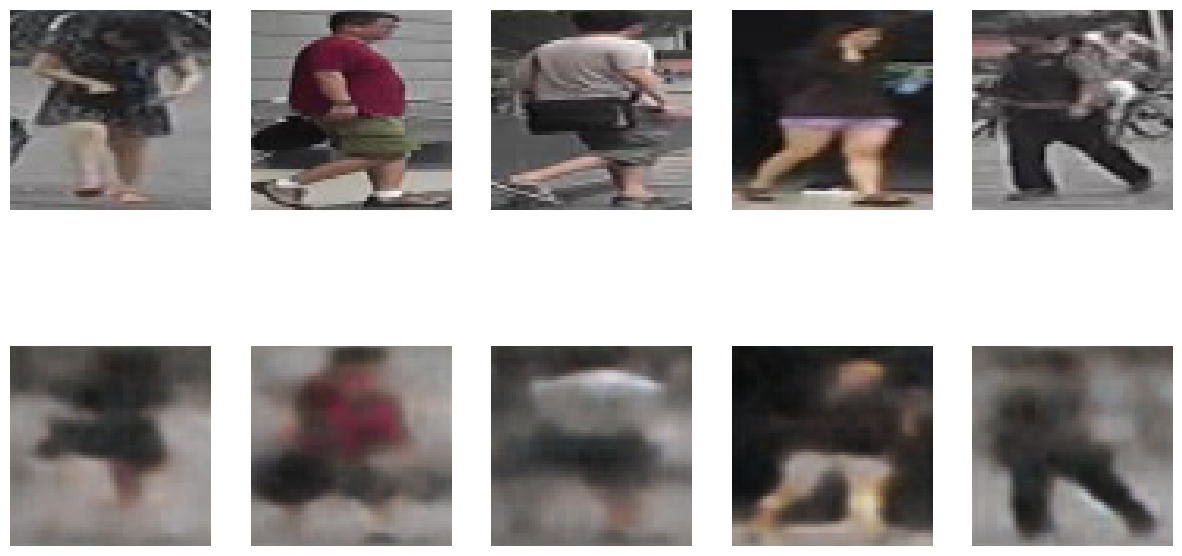

In [ ]:
# Test reconstruction

x_test=[]
for i in range(len(imagePathsTest)):
  image=plt.imread(imagePaths[i])
  image=cv2.resize(image, (64, 64))
  image = image/255
  x_test.append(image)
x_test=np.array(x_test)

reconstructed_img = autoencoder_dr(x_test[0:5])

f, axs = plt.subplots(2, 5, figsize=(15, 8))
for j in range(5):
    axs[0, j].imshow(x_test[j], cmap='binary')
    axs[1, j].imshow(reconstructed_img[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [ ]:
# Write features to files

fp = open("autoencoder_features_v4.txt", "w")
for i in imagePaths:
  try:
    image=plt.imread(i)
    image = image/255
    image=cv2.resize(image, (64, 64))
    print(i+","+",".join(map(str, encoder(np.array([image])).numpy()[0].tolist())))
    fp.write(i+","+",".join(map(str, encoder(np.array([image])).numpy()[0].tolist()))+"\n")
  except:
    pass
fp.close()